<h2>Imports<h2>

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path

<p>Reading the document<p>

In [104]:
#Open Excel files with different extensions
filename = 'train.csv'
file_path = Path(filename)
file_extension = file_path.suffix.lower()[1:]

if file_extension == 'xlsx':
    d = pd.read_excel(file_path, engine='openpyxl')
    data = d.copy()
elif file_extension == 'xls':
    d = pd.read_excel(file_path)
    data = d.copy()
elif file_extension == 'csv':
    d = pd.read_csv(file_path, delimiter=";")
    data = d.copy()
else:
    raise Exception("File not supported")


<h3>Data Head<h3>

In [105]:
data.head()

,Cust_ID,Churn,Name,Longevity,Year_Birth,TypeTravel,RoomType,RewardPoints,Comfort,ReceptionSchedule,...,Wifi,Amenities,Staff,OnlineBooking,PriceQuality,RoomSpace,CheckOut,Checkin,Cleanliness,BarService
0,1,churn,Ms. Nicole Clarke,yes,1974.0,business,single,4907,3,4,...,4,3,4,3,3,3,3,4,3,4
1,2,nochurn,Mr. Jesse Scott,yes,1965.0,business,single,6724,1,1,...,5,3,4,5,5,5,5,1,5,2
2,3,churn,Mr. Christopher Carter,yes,1973.0,business,single,4365,3,3,...,1,4,4,3,3,2,3,2,3,1
3,4,nochurn,Ms. Jennifer Morgan,yes,1993.0,leisure,double,3849,1,1,...,4,4,5,4,4,4,4,4,4,3
4,5,nochurn,Mr. Michael White,yes,1989.0,business,single,5376,2,2,...,5,5,5,5,5,3,4,1,3,5


<h3>Data Info<h3>

In [106]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15589 entries, 0 to 15588
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cust_ID            15589 non-null  int64  
 1   Churn              15589 non-null  object 
 2   Name               15589 non-null  object 
 3   Longevity          15589 non-null  object 
 4   Year_Birth         15394 non-null  float64
 5   TypeTravel         15589 non-null  object 
 6   RoomType           15589 non-null  object 
 7   RewardPoints       15589 non-null  int64  
 8   Comfort            15589 non-null  int64  
 9   ReceptionSchedule  15589 non-null  int64  
 10  FoodDrink          15589 non-null  int64  
 11  Location           15589 non-null  int64  
 12  Wifi               15589 non-null  int64  
 13  Amenities          15589 non-null  int64  
 14  Staff              15589 non-null  int64  
 15  OnlineBooking      15589 non-null  int64  
 16  PriceQuality       155

In [107]:
data.shape

(15589, 22)

<h3>Looking for Null values<h3>

In [108]:
data.isna().sum()/len(data)*100

Cust_ID              0.000000
Churn                0.000000
Name                 0.000000
Longevity            0.000000
Year_Birth           1.250882
TypeTravel           0.000000
RoomType             0.000000
RewardPoints         0.000000
Comfort              0.000000
ReceptionSchedule    0.000000
FoodDrink            0.000000
Location             0.000000
Wifi                 0.000000
Amenities            0.000000
Staff                0.000000
OnlineBooking        0.000000
PriceQuality         0.000000
RoomSpace            0.000000
CheckOut             0.000000
Checkin              0.000000
Cleanliness          0.000000
BarService           0.000000
dtype: float64

<h3> Find outliers in Year_Birth and RewardPoints <h3>

<h3>Use KNN inputer for the missing values in Year_Birth <h3>

In [111]:
data['Longevity'].value_counts()

yes    12427
no      2838
y        129
Name: Longevity, dtype: int64

In [112]:
data['Longevity'].replace(to_replace = 'yes',value = 1, inplace = True)
data['Longevity'].replace(to_replace = 'y',value = 1, inplace = True)
data['Longevity'].replace(to_replace = 'no',value = 0, inplace = True)
data['Longevity'].value_counts()

1    12556
0     2838
Name: Longevity, dtype: int64

<h3>Changing the Values of Column "TypeTravel"<h3>
 <p>business = 1 leisure = 0 <p>

In [113]:
data['TypeTravel'].value_counts()

business    10627
leisure      4767
Name: TypeTravel, dtype: int64

In [114]:
data['TypeTravel'].replace(to_replace = 'business',value = 1, inplace = True)
data['TypeTravel'].replace(to_replace = 'leisure',value = 0, inplace = True)
data['TypeTravel'].value_counts()

1    10627
0     4767
Name: TypeTravel, dtype: int64

<h3>Changing the Values of Column "Wifi"<h3>
 <p>6 were Replaced by 5 <p>

<AxesSubplot:xlabel='Wifi'>

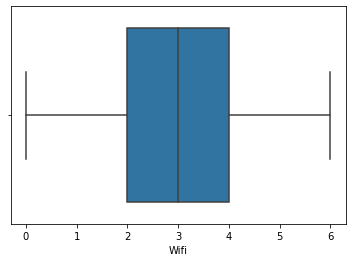

In [115]:
sns.boxplot(x="Wifi", data = data[['Wifi']])

In [116]:
data['Wifi'].value_counts()

4    3667
5    3396
3    3307
2    3190
1    1780
6      36
0      18
Name: Wifi, dtype: int64

In [117]:
data['Wifi'].replace(to_replace = 6,value = 5, inplace = True)
data['Wifi'].value_counts()

4    3667
5    3432
3    3307
2    3190
1    1780
0      18
Name: Wifi, dtype: int64

<h3>Changing the Values of Column "Churn"<h3>
 <p>convert "churn" and "nochurn" to 1 (True) and 0 (False) <p>

In [118]:
data['Churn'].value_counts()

nochurn    8354
churn      7040
Name: Churn, dtype: int64

In [119]:
data['Churn'].replace(to_replace = 'churn',value = 1, inplace = True)
data['Churn'].replace(to_replace = 'nochurn',value = 0, inplace = True)
data['Churn'].value_counts()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15394 entries, 0 to 15588
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cust_ID            15394 non-null  int64  
 1   Churn              15394 non-null  int64  
 2   Name               15394 non-null  object 
 3   Longevity          15394 non-null  int64  
 4   Year_Birth         15394 non-null  float64
 5   TypeTravel         15394 non-null  int64  
 6   RoomType           15394 non-null  object 
 7   RewardPoints       15394 non-null  int64  
 8   Comfort            15394 non-null  int64  
 9   ReceptionSchedule  15394 non-null  int64  
 10  FoodDrink          15394 non-null  int64  
 11  Location           15394 non-null  int64  
 12  Wifi               15394 non-null  int64  
 13  Amenities          15394 non-null  int64  
 14  Staff              15394 non-null  int64  
 15  OnlineBooking      15394 non-null  int64  
 16  PriceQuality       153

Room Type change?

In [120]:
data['RoomType'].value_counts()

single    7350
double    6932
suite     1112
Name: RoomType, dtype: int64

<h3>Pearson Correlation Heatmap<h3>

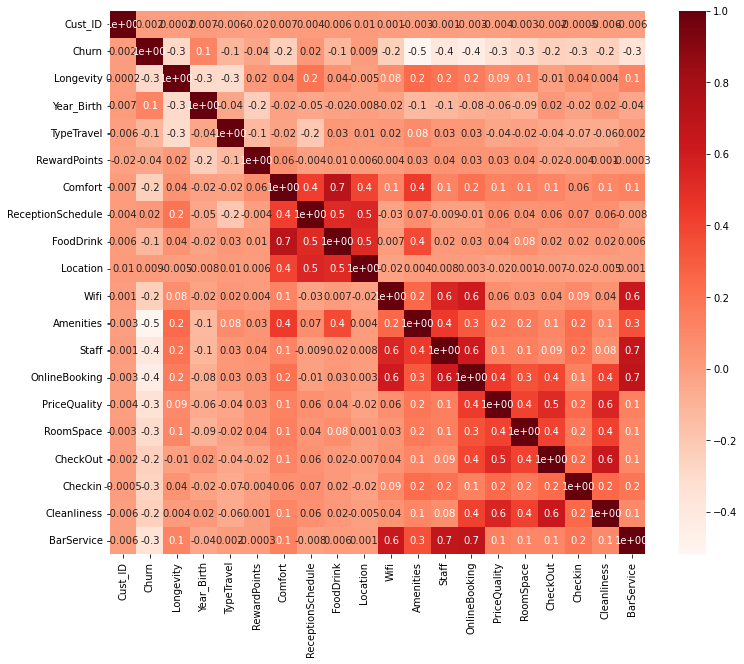

In [121]:
#pearson correlation
cor_pearson = data.corr(method ='pearson')
#Heatmap function defined
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
#print correlation
cor_heatmap(cor_pearson)